In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [ ]:
columns = ['date', 'text', 'weight']
target = ['negative']

In [ ]:
# we will need to use pyspark to connect to our joined_v001.csv file in AWS S3
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://ppa.lau

In [ ]:
# Download a Postgres driver that will allow Spark to interact with Postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar


--2022-08-25 00:32:12--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  1.58MB/s    in 0.6s    

2022-08-25 00:32:14 (1.58 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [ ]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TwitterEnsemble").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://jessehernandez70test1.s3.us-west-1.amazonaws.com/joined_v001.csv"

spark.sparkContext.addFile(url)
joined_data_df = spark.read.csv(SparkFiles.get("joined_v001.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
joined_data_df.show()

+----------+--------------------+-----------+-----+------+
|      date|                text|   negative|event|weight|
+----------+--------------------+-----------+-----+------+
|2022-08-01|the conflict is b...|0.602711678| null|  null|
|2022-08-01|remember when sma...|0.212250158| null|  null|
|2022-08-01|hi  you have to u...|0.490129501| null|  null|
|2022-08-01|the world is in d...|0.876022816| null|  null|
|2022-08-01|will the imposed ...|0.044509333| null|  null|
|2022-08-01|owner of ukraines...| 0.83338201| null|  null|
|2022-08-01|animal shelter do...|0.013312108| null|  null|
|2022-08-01|    eb5f211900p4acc7|0.254985869| null|  null|
|2022-08-01|why  relations li...|0.409764558| null|  null|
|2022-08-01|crypto tattoos to...|0.005395876| null|  null|
|2022-08-01|its happening on ...|0.061495773| null|  null|
|2022-08-01|will certainly lo...|0.881493032| null|  null|
|2022-08-01|serbian vucic is ...|0.974542975| null|  null|
|2022-08-01|animal shelter do...|0.013312108| null|  nul

In [ ]:
# Show the end of DataFrame
joined_data_df.tail(10) 

[Row(date='2022-08-12', text='would a president pence pardon an impeached trump  via', negative=None, event='\xa0Battles in eastern Ukraines Donetsk region continued with Russian forces conducting ground attacks in different locations including around the city of Bakhmut east of Siversk and northwest of the city of Donetsk', weight=0.5),
 Row(date='2022-08-12', text='conservatives say trump is not the nomineeso who is', negative=None, event='\xa0Battles in eastern Ukraines Donetsk region continued with Russian forces conducting ground attacks in different locations including around the city of Bakhmut east of Siversk and northwest of the city of Donetsk', weight=0.5),
 Row(date='2022-08-12', text='genioux fact  and their governments have become the true enemies of the fabulous and people predators as hyper mistaken as aggressive', negative=None, event='\xa0Battles in eastern Ukraines Donetsk region continued with Russian forces conducting ground attacks in different locations including

In [ ]:
# convert spark dataframe to pandas

import pandas as pd
joined_data_df = joined_data_df.toPandas()
print(joined_data_df)




               date                                               text  \
0        2022-08-01  the conflict is being cast in binaries making ...   
1        2022-08-01  remember when smashed into seven fragments and...   
2        2022-08-01  hi  you have to understand that we are billion...   
3        2022-08-01  the world is in dire straits as it is not equi...   
4        2022-08-01  will the imposed on cause a significant shift ...   
...             ...                                                ...   
1048570  2022-08-12  conservatives say trump is not the nomineeso w...   
1048571  2022-08-12  s treason is what we get for letting  if youre...   
1048572  2022-08-12  trump and saudi arabia looks like theyve paid ...   
1048573  2022-08-12  i pray for the ukrainian people i want to be s...   
1048574  2022-08-12  refused to show his taxes that should have bee...   

         negative                                              event  weight  
0        0.602712               

In [ ]:
# convert text to text lenght
joined_data_df['text_length']  = joined_data_df['text'].str.len()

joined_data_df.head()

,date,text,negative,event,weight,text_length
0,2022-08-01,the conflict is being cast in binaries making ...,0.602712,None,NaN,73
1,2022-08-01,remember when smashed into seven fragments and...,0.212250,None,NaN,108
2,2022-08-01,hi you have to understand that we are billion...,0.490130,None,NaN,112
3,2022-08-01,the world is in dire straits as it is not equi...,0.876023,None,NaN,130
4,2022-08-01,will the imposed on cause a significant shift ...,0.044509,None,NaN,128


In [ ]:
# Drop the columns with text values
joined_data_df.drop("text", axis=1, inplace=True)
joined_data_df.drop("event", axis=1, inplace=True)

joined_data_df.head()

,date,negative,weight,text_length
0,2022-08-01,0.602712,NaN,73
1,2022-08-01,0.212250,NaN,108
2,2022-08-01,0.490130,NaN,112
3,2022-08-01,0.876023,NaN,130
4,2022-08-01,0.044509,NaN,128


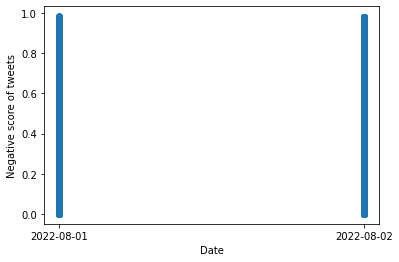

In [ ]:
# Get the plot 

# importing the plot module
import matplotlib.pyplot as plt

plt.scatter(joined_data_df.date, joined_data_df.negative)
plt.xlabel('Date')
plt.ylabel('Negative score of tweets')
plt.show()

In [ ]:
# convert datetime to numerical

# importing the datetime module
import datetime as dt
 
joined_data_df['date'] = pd.to_datetime(joined_data_df['date'])

joined_data_df['date'] = joined_data_df['date'].map(dt.datetime.toordinal)

In [ ]:
joined_data_df.head()

,date,negative,weight,text_length
0,738368,0.602712,NaN,73
1,738368,0.212250,NaN,108
2,738368,0.490130,NaN,112
3,738368,0.876023,NaN,130
4,738368,0.044509,NaN,128


In [ ]:
joined_data_df.tail()

,date,negative,weight,text_length
1048570,738379,NaN,0.5,51
1048571,738379,NaN,0.5,212
1048572,738379,NaN,0.5,224
1048573,738379,NaN,0.5,200
1048574,738379,NaN,0.5,260


In [ ]:
# Drop the null rows
# joined_data_df = joined_data_df.dropna()

In [ ]:
# get the shape of the new DataFrame
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

1048575 rows and 4 columns


In [ ]:
joined_data_df.head()

,date,negative,weight,text_length
0,738368,0.602712,NaN,73
1,738368,0.212250,NaN,108
2,738368,0.490130,NaN,112
3,738368,0.876023,NaN,130
4,738368,0.044509,NaN,128


In [ ]:
joined_data_df.tail()

,date,negative,weight,text_length
1048570,738379,NaN,0.5,51
1048571,738379,NaN,0.5,212
1048572,738379,NaN,0.5,224
1048573,738379,NaN,0.5,200
1048574,738379,NaN,0.5,260


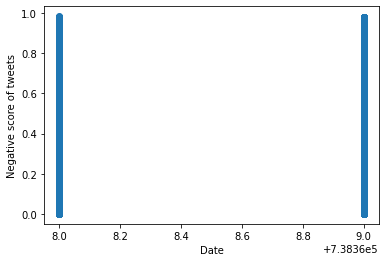

In [ ]:
# Get the plot 

# importing the plot module
import matplotlib.pyplot as plt

plt.scatter(joined_data_df.date, joined_data_df.negative)
plt.xlabel('Date')
plt.ylabel('Negative score of tweets')
plt.show()

# Linear regression

Let's just to try most simple model to see how it works

In [ ]:
# Import 
from sklearn.linear_model import LinearRegression 

model = LinearRegression()

In [ ]:
# Create our features
X = joined_data_df.drop(columns='negative')

# Create our target
y = joined_data_df['negative']



In [ ]:
#Train model

model.fit(X, y)

ValueError: ignored

In [ ]:
y_pred = model.predict(X)
print(y_pred.shape)

ValueError: ignored

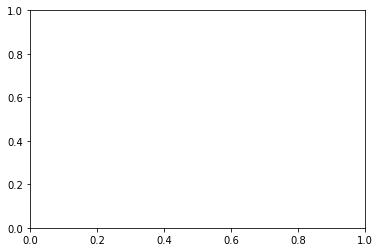

In [ ]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [ ]:
X.describe()

,date,weight,text_length
count,1.048575e+06,146968.000000,1.048575e+06
mean,7.383719e+05,0.410681,1.306502e+02
std,2.868063e+00,0.099428,7.431145e+01
min,7.383680e+05,0.300000,1.000000e+00
25%,7.383690e+05,0.300000,6.400000e+01
50%,7.383720e+05,0.500000,1.280000e+02
75%,7.383740e+05,0.500000,1.990000e+02
max,7.383790e+05,0.500000,2.790000e+02


In [ ]:
# Check the balance of our target values
y.value_counts()

0.003370    2434
0.002942    1986
0.212250    1788
0.632084    1217
0.087129     829
            ... 
0.037779       1
0.012595       1
0.615169       1
0.238719       1
0.520103       1
Name: negative, Length: 36328, dtype: int64

# Ensemble Learners

In this section, we try to compare two ensemble algorithms to determine which algorithm results in the best performance. 

# Balanced Random Forest Classifier

In [ ]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators =100, random_state=1).fit(X_train, y_train)

In [ ]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = rf_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

In [ ]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

In [ ]:
# List the features sorted in descending order by feature importance
priority_features = pd.Series(data=rf_model.feature_importances_,index=X.columns)
priority_features.sort_values(ascending=False,inplace=True)
print(priority_features)

# Easy Ensemble AdaBoost Classifier

In [ ]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
eec_model = EasyEnsembleClassifier(n_estimators =100, random_state=1).fit(X_train, y_train)

In [ ]:
# Calculated the balanced accuracy score
y_pred = eec_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

In [ ]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))